# ЗАДАЧА от РЖД: Автоматизация

## Установка библиотек

In [ ]:
!pip install surprise

## Импорт библиотек, методов, классов

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
import sklearn

import surprise

from matplotlib.patches import Rectangle

## Функции, нужные для расчета параметров:

* функция для визуализации схемы размещения груза на открытой платформе:

In [ ]:
def plotBox (x,y, bias_x=0, bias_y=0, lp =0):

    x0 = x+bias_x
    y0 = y+bias_y

    x_centr = x0 - x/2
    y_centr = y0 - y/2


    xx = [bias_x, x0, x0, bias_x, bias_x]
    yy = [bias_y , bias_y ,y0, y0, bias_y]
    ax.plot(xx, yy, color="blue", linewidth=3)

    ax.plot(x_centr, y_centr,  marker="o", markersize=markersize, color="red")
    ax.text (x_centr-100, y_centr+100, f'ЦТгр {lp}')

In [ ]:
add_width_text = 200
add_height_text = 5


add_width  = 1000
add_height = 200


def plotArrow_W(x,y, bias_x=0, bias_y=0, direction = 1, y_top = 0, centr =0):
    head_width = 50
    add_width  = x/2
    # add_height = 100

    # add_width_text = 50
    # add_height_text = 50

    x0 = bias_x
    y0 = bias_y

    y1 = y0
    y2 = y0 + y

    if y_top ==0:
        y3 = y2 + (add_height)*direction
    else:
        y3 = y_top


    y4 = y3 - (add_height/2)*direction

    if direction== -1:
        y3 = y1 + (add_height)*direction
        y4 = y3 - (add_height/2)*direction


    x1 = x0
    x2 = x0+x

    x3 = x2 + add_width
    x4 = x3 - add_width/2



    xx = [x1, x1]
    yy = [y1 , y3]
    ax.plot(xx, yy, color="red")

    xx = [x2 , x2]
    yy = [y1 , y3]
    ax.plot(xx, yy, color="red")


    ax.arrow( x1 , y4,   x-head_width*2 , 0 , head_width = head_width,  color="black",  width=1)
    ax.arrow( x2 , y4,  -x+head_width*2 , 0 , head_width = head_width,  color="black",  width=1)
    ax.text (x1+(x/2)-30, y3+add_height_text, x)

def plotArrow_H(x,y, bias_x=0, bias_y=0, direction = 1, centr=1, x_top = 0, to_floor=0):


    head_width = 50
    add_width  = x/4
    add_height = y/4

    # add_width_text = 50
    # add_height_text = 50

    x0 = bias_x
    y0 = bias_y

    y1 = bias_y
    y2 = y+bias_y

    y3 = y2 + add_height
    y4 = y3 - add_height/2

    x1 = bias_x
    x2 = x1 + x

    if direction == 1:
        x3 = x1 - add_width
        x4 = x3 + add_width/2
    else:
        x3 = x1 + add_width
        x4 = x3 - add_width/2

    if to_floor == 1:
        y1 = 0
        x3 = x1 + add_width*3
        x4 = x3 - add_width/2
        y = y2


    xx = [x1, x3]
    yy = [y1 , y1]
    ax.plot(xx, yy, color="red")

    xx = [x1 , x3]
    yy = [y2 , y2]
    ax.plot(xx, yy, color="red")

    ax.arrow( x4 , y1,  0 , y - head_width*2, head_width = head_width,  color="black",  width=1)
    ax.arrow( x4 , y2,  0 , -y + head_width*2, head_width = head_width,  color="black",  width=1)
    ax.text (x3-30, y1+(y/2), y, rotation = 90)

* функции для расчета параметров размещения груза:

In [86]:
def bias_prod(df):
  L_c=(0.5*13300-(df['вес_единицы']*df['L_i']*df['количество']).sum()/(df['вес_единицы']*df['количество']).sum()).round(0)
  return L_c

In [93]:
def total_H_ct (df):
  H_ct = ((df['вес_единицы']*df['h_i']*df['количество']).sum()/(df['вес_единицы']*df['количество']).sum()).round(0)
  return H_ct

In [152]:
def total_H_o_ct(df):
  delta = ((df['масса_тары']*df['высота_ЦТ_от_УГР']))
  H_o_ct=(((df['вес_единицы']*df['h_i']*df['количество']).sum()+delta)/((df['вес_единицы']*df['количество']).sum()+df['масса_тары'])).round(0)
  return H_o_ct

In [200]:
def iner_a_prod(df):
  iner_a_prod=(df['a_22'] - (0.001*(df['вес_единицы']*df['количество']).sum()*(df['a_22']-df['a_94']))/72).round(3)
  return iner_a_prod

## Загрузка исходных данных о грузе и платформе:

In [175]:
 df = pd.read_csv('order_1.csv', sep=';', header = 0, decimal=",")
 df.head()

,orderid,тип_платформы,модель_платформа,длина_пола,ширина_пола,масса_тары,высота_пола_от_УГР,высота_ЦТ_от_УГР,база_платформы,тип_настила_пола,...,nu_pr,nu_pr_lim,nu_p,nu_p_lim,R_gv,F_pr_br,sigma_c_pp,sigma_c_pp_lim,sigma_c_prod,sigma_c_prod_lim
0,1,четырехосная,13-401,13400,2870,21,1310,800,9720,сплошной деревянный,...,NaN,1.25,NaN,1.25,108,NaN,NaN,12,NaN,120
1,1,четырехосная,13-401,13400,2870,21,1310,800,9720,сплошной деревянный,...,NaN,1.25,NaN,1.25,108,NaN,NaN,12,NaN,120
2,1,четырехосная,13-401,13400,2870,21,1310,800,9720,сплошной деревянный,...,NaN,1.25,NaN,1.25,108,NaN,0.0,12,0.0,120
3,1,четырехосная,13-401,13400,2870,21,1310,800,9720,сплошной деревянный,...,NaN,1.25,NaN,1.25,108,NaN,0.0,12,0.0,120


* расчет параметров размещения груза на платформе:

In [ ]:
df.info()

In [182]:
# Смещение ЦТ грузов в вагоне:
df['L_c']=bias_prod(df)

In [183]:
# Общая высота ЦТ:
df['H_ct']=total_H_ct(df)

In [184]:
# Общая высота ЦТ:
df['H_ct']=total_H_ct(df)

In [185]:
# Устойчивость грузов с вагоном
## Общая высота ЦТ

df['H_o_ct']=total_H_o_ct(df)

In [186]:
## Расчет наветренной поверхности

df['S_bok']=5.07+3.7+0.42+4.72+7

In [223]:
# Расчет сил, действующих на Груз № 1
## Продольная инерционная сила

df['a_prod'] = iner_a_prod(df)
df['F_prod'][0] = (df['a_prod'][0] *0.001*(df['вес_единицы'][0] *df['количество'][0])).round(3)

## Поперечная инерционная сила
df['a_pp'] = (0.33 + 0.44*(3595/df['база_платформы'])).round(3)
df['F_pp'][0] = (df['a_pp'][0] *0.001*(df['вес_единицы'][0] *df['количество'][0])).round(2)

## Вертикальная инерционная сила


## Ветровая нагрузка


## Сила трения в продольном направлении


## Сила трения в поперечном направлении


## Усилия которые должны восприниматься средствами крепления
### Продольное:


### Поперечное:


<ipython-input-223-b47be2a86668>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['F_prod'][0] = (df['a_prod'][0] *0.001*(df['вес_единицы'][0] *df['количество'][0])).round(3)
<ipython-input-223-b47be2a86668>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['F_pp'][0] = (df['a_pp'][0] *0.001*(df['вес_единицы'][0] *df['количество'][0])).round(2)


In [ ]:
# Расчет сил, действующих на Груз № 2


In [ ]:
# Расчет сил, действующих на Груз № 3


In [ ]:
# Расчет сил, действующих на Груз № 4


In [224]:
df['F_pp'].head()

0    3.29
1     NaN
2     NaN
3     NaN
Name: F_pp, dtype: float64

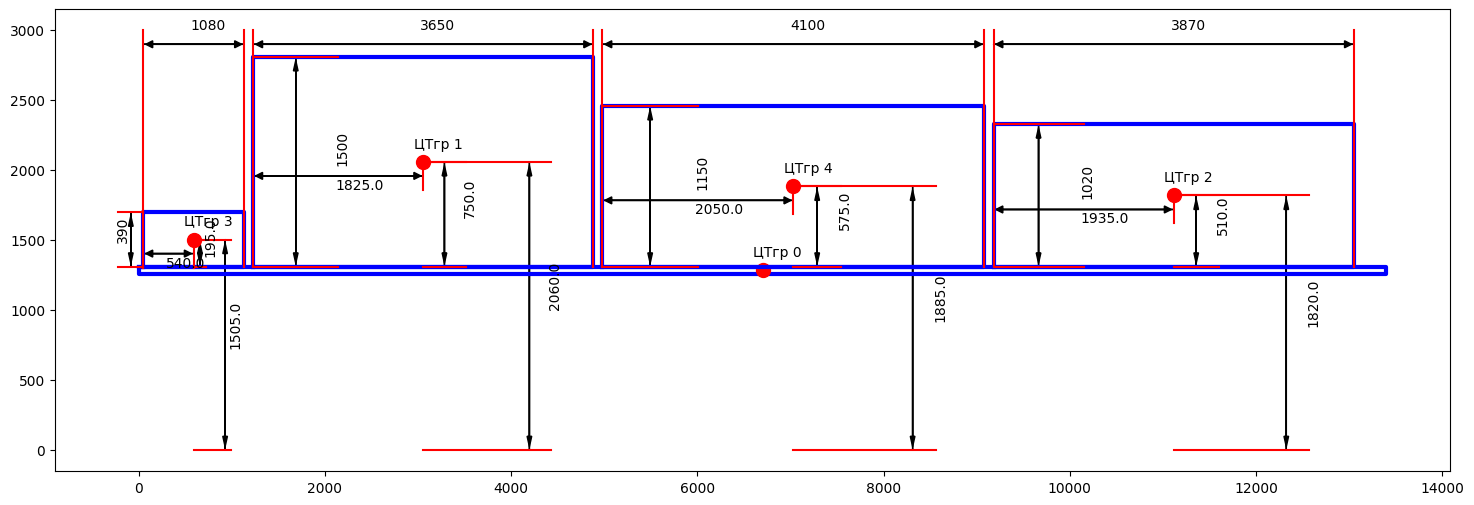

In [ ]:
# визуализация схемы размещения груза на платформе после выполнения расчета параметров:

cm = 1/2.54  # centimeters in inches

# fig, ax = plt.subplots(figsize=(15*cm, 5*cm))

fig, ax = plt.subplots(figsize=(18, 6))

# ax.plot(14000, 6000, color="black")
markersize = 10

nn = 1000
    # plotArrow(x_centr,y, bias_x=x_centr, bias_y=0)

bias_x = 0
bias_y = 0
bias_y = 1310




x = 13400
y = -50
plotBox (x,y,bias_x, bias_y )

ax.plot([0,x ], [0, 0], color="black", linewidth=0)

bias_x = 50

direction = 1


for i in [3, 1, 4, 2 ]:
    x = A[i][1]
    y = A[i][3]
    plotBox (x,y,bias_x, bias_y, lp=i )

    plotArrow_W(x,y,bias_x, bias_y,  direction=1,  y_top=3000 )
    if x < 2000:
        direction=1
    else:
        direction=-1
    plotArrow_H(x,y,bias_x, bias_y,  direction = direction )

    x0 = x+bias_x
    y0 = y+bias_y
    x_centr = x - x/2
    y_centr = y - y/2

    plotArrow_W(x_centr, y_centr, bias_x, y_centr+bias_y, direction=-1)
    plotArrow_H(x_centr, y_centr, x_centr+bias_x, bias_y, direction=-1)

    plotArrow_H(x_centr, y_centr, x_centr+bias_x, bias_y, direction=-1,to_floor =1)

    bias_x =bias_x + x +100

plt.show()